# Web Scrapping

## Integrantes

- Casais, Francisco
- Eberle, Lautaro

## Resumen

Para esta actividad elegimos extraer alrededor de 30 filas de datos acerca de celulares a la venta en la página web de Frávega en [esta URL](https://www.fravega.com/l/celulares/). El archivo CSV resultante al momento en el que ejecutamos el código fue [este](../csv/fravega-celulares.csv). Posteriormente hicimos algunos gráficos para analizar estos datos.

## Extracción de datos

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

diccionario = {}
marca = []
modelo = []
descuento = []
precio_anterior = []
precio_actual = []

def obtener_marca_y_modelo(palabras):
  global marca
  global modelo
  marca_no_encontrada = True
  modelo_actual = ""
  for palabra in palabras:
    if marca_no_encontrada and palabra != "Celular":
      marca.append(palabra)
      marca_no_encontrada = False
    elif not marca_no_encontrada and modelo_actual == "":
      modelo_actual = palabra
    elif not marca_no_encontrada and modelo_actual != "":
      modelo_actual = modelo_actual + " " + palabra
  modelo.append(modelo_actual)

def obtener_datos(celulares):
  global descuento
  global precio_anterior
  global precio_actual
  for celular in celulares:
    obtener_marca_y_modelo(celular.find("span", class_ = "sc-ca346929-0 czeMAx").getText().split())
    if not celular.find("span", class_ = "sc-e2aca368-0 juwGno") is None:
      descuento.append(int(celular.find("span", class_ = "sc-e2aca368-0 juwGno").getText()))
    else:
      descuento.append("-")
    if not celular.find("span", class_= "sc-66d25270-0 eiLwiO") is None:
      precio_anterior.append(int(celular.find("span", class_= "sc-66d25270-0 eiLwiO").getText()[1:].replace(".", "")))
    else:
      precio_anterior.append("-")
    precio_actual.append(int(celular.find("span", class_ = "sc-1d9b1d9e-0 OZgQ").getText()[1:].replace(".", "")))

pagina = requests.get("https://www.fravega.com/l/celulares/")
objeto_sopa = BeautifulSoup(pagina.content, 'html.parser')

ofertas_destacadas = objeto_sopa.find_all("li", class_= "sc-237b4ecc-1 sc-54b38ae1-1 brHJQg jnmFMy")
demas_celulares = objeto_sopa.find_all("article", class_ = "sc-812c6cb5-2 hblEKG")

obtener_datos(ofertas_destacadas)
obtener_datos(demas_celulares)

diccionario["Marca"] = marca
diccionario["Modelo"] = modelo
diccionario["Descuento (%)"] = descuento
diccionario["Precio anterior (ARS)"] = precio_anterior
diccionario["Precio actual (ARS)"] = precio_actual

data = pd.DataFrame(diccionario)
data.to_csv("../csv/fravega-celulares.csv")

## Gráficos

### Gráfico de torta: Marcas

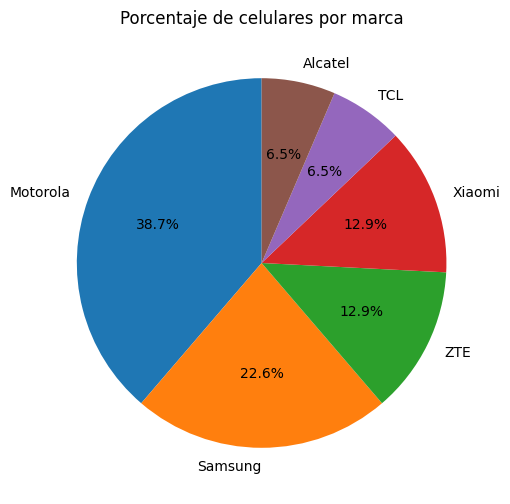

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../csv/fravega-celulares.csv")
cant_por_marca = df["Marca"].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(cant_por_marca, labels=cant_por_marca.index, autopct="%1.1f%%", startangle=90)
plt.title("Porcentaje de celulares por marca")

plt.show()

Gracias a este gráfico de torta, que muestra el porcentaje de celulares que pertenecen a una determinada marca, podemos ver que las marcas más populares son Motorola y Samsung.

### Gráfico de barras: Precio promedio por marca

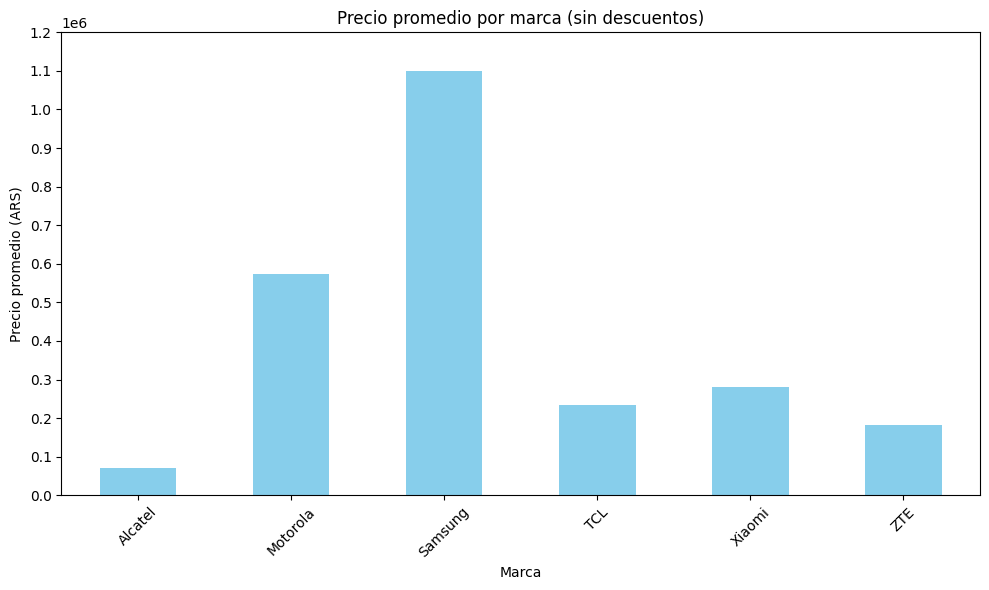

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../csv/fravega-celulares.csv")
precio_prom_por_marca = df.groupby("Marca")["Precio actual (ARS)"].mean()

plt.figure(figsize=(10, 6))
precio_prom_por_marca.plot(kind="bar", color="skyblue")
plt.xlabel("Marca")
plt.ylabel("Precio promedio (ARS)")
plt.title("Precio promedio por marca (sin descuentos)")
plt.xticks(rotation=45)
plt.yticks(range(0, int(precio_prom_por_marca.max() + 100000), 100000))

plt.tight_layout()
plt.show()

Este gráfico nos muestra el precio promedio sin descuentos aplicados de los celulares agrupados por su marca. Podemos ver que Samsung es con diferencia la marca más cara con un promedio de alrededor de 1,1 millones de pesos, seguida de Motorola con casi 600 mil. Esto tiene sentido teniendo en cuenta que son las dos marcas con más renombre de entre las que encontramos en el gráfico; mientras que Alcatel, conocida por ser una alternativa low-cost, es la más barata de todas, con menos de 100 mil pesos de promedio.

### Gráfico de torta: Celulares con y sin descuento

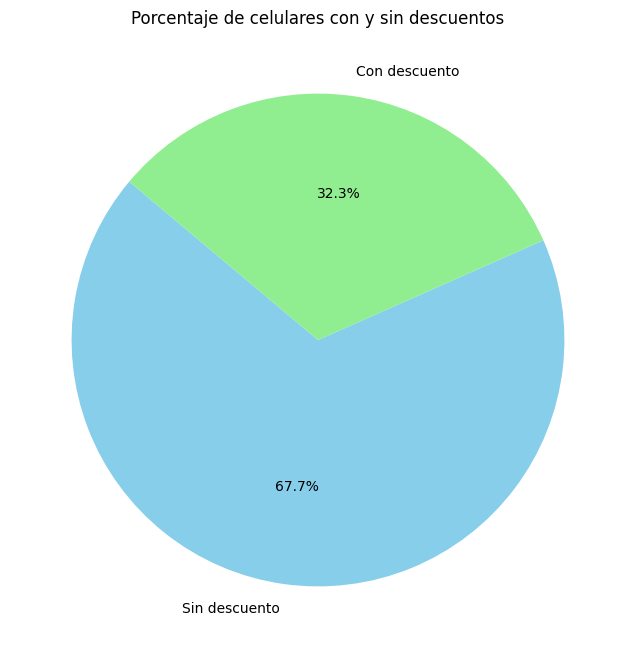

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../csv/fravega-celulares.csv")
df["Con descuento"] = df["Descuento (%)"]!="-"
sin_descuento = df["Con descuento"].value_counts().get(False, 0)
con_descuento = df["Con descuento"].value_counts().get(True, 0)

labels = ["Sin descuento", "Con descuento"]
sizes = [sin_descuento, con_descuento]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightgreen"])
plt.title("Porcentaje de celulares con y sin descuentos")

plt.show()

Podemos ver que la mayoría de los celulares que se encontraban en la página no tenían ningún descuento ni oferta. Sin embargo, del 32% que sí lo tienen, vamos a realizar un pequeño análisis con el próximo gráfico.

### Gráfico de puntos: Precios con y sin descuento

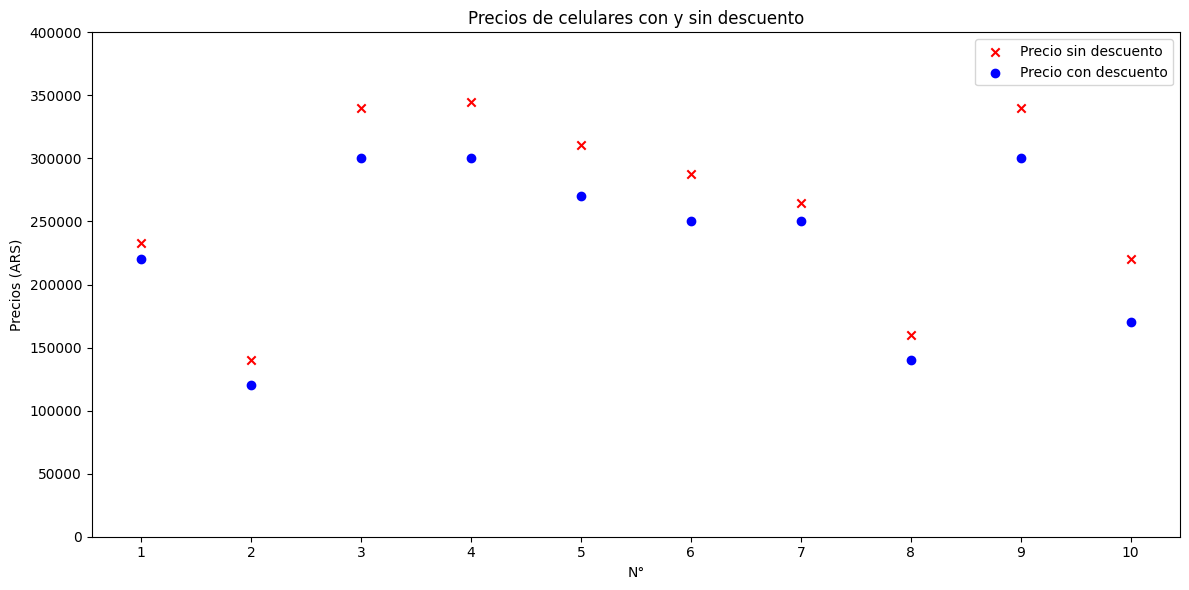

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../csv/fravega-celulares.csv")
df["Precio anterior (ARS)"] = pd.to_numeric(df["Precio anterior (ARS)"], errors="coerce")
df["Precio actual (ARS)"] = pd.to_numeric(df["Precio actual (ARS)"], errors="coerce")
df_descuento = df[df["Descuento (%)"] != "-"]

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = range(1, len(df_descuento) + 1)
ax.scatter(x_pos, df_descuento["Precio anterior (ARS)"], color="red", marker="x", label="Precio sin descuento")
ax.scatter(x_pos, df_descuento["Precio actual (ARS)"], color="blue", marker="o", label="Precio con descuento")
ax.set_xticks(x_pos)
ax.set_xlabel("N°")
ax.set_ylabel("Precios (ARS)")
ax.set_ylim(0, max(df_descuento["Precio anterior (ARS)"].max(), df_descuento["Precio actual (ARS)"].max()) + 50000)
ax.set_yticks(range(0, int(max(df_descuento["Precio anterior (ARS)"].max(), df_descuento["Precio actual (ARS)"].max()) + 100000), 50000))
ax.set_title("Precios de celulares con y sin descuento")
ax.legend()

plt.tight_layout()
plt.show()

Podemos ver claramente que ninguno de los descuentos es muy significativo. De hecho, el mayor descuento que encontramos solamente ahorra alrededor de 50 000 pesos en un celular que cuesta casi 225 000.